In [1]:
import os
os.chdir('C:/Users/tm/Downloads/utas/thesis/chapter1/tasmania/data')

import numpy as np
from pyproj import Proj
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import geopandas as gpd
import ast
from shapely.geometry import box
import rasterio
from rasterio.features import rasterize
from rasterio.transform import from_origin

### functions

In [2]:
def rescale_minmax(arr):
    return (arr-arr.min())/(arr.max()-arr.min())

In [3]:
#coordinates conversion
def convert_easting_northing_to_lat_lon(easting, northing,):
    proj = Proj('+proj=utm +zone=55 +south +ellps=GRS80 +units=m +no_defs')
    lon, lat = proj(easting, northing, inverse=True)
    return lat, lon

In [4]:
#rescale value
def rescale_value(old_value, min_old_value, max_old_value, min_new_value, max_new_value):
    scaled_value = ((old_value - min_old_value) / (max_old_value - min_old_value)) * (
        max_new_value - min_new_value) + min_new_value
    return scaled_value

In [5]:
def rescale_percentile(input_series,upper=80,lower=20):
    arr=input_series.copy(deep=True)
    arr[arr<np.percentile(arr,lower)]=np.percentile(arr,lower)
    arr[arr>np.percentile(arr,upper)]=np.percentile(arr,upper)
    return arr

### global variables

In [6]:
lonmin=144.165967
latmin=-43.833736
lonmax=148.576978
latmax=-40.349895
lat_centre=-42.10904672752227
lon_centre=146.6417533511285
gridlen=35
bbox=box(lonmin,latmin,lonmax,latmax)

### bioregion

In [7]:
# #read
# gdf=gpd.read_file('Interim_Biogeographic_Regionalisation_for_Australia_(IBRA)_Version_7_(Regions).geojson')

# #clip each shape
# clipped=[]
# code=[]
# for i in gdf.index:
#     clipped_geometry=gdf.at[i,'geometry'].intersection(bbox)
#     if not clipped_geometry.is_empty:
#         clipped.append(clipped_geometry)
#         code.append(gdf.at[i,'REG_CODE_7'])

# # Create a new GeoDataFrame from the clipped geometries
# clipped_gdf=gpd.GeoDataFrame(geometry=clipped,crs=gdf.crs)
# clipped_gdf['regcode']=code

# #map id
# mapping,clipped_gdf['id']=np.unique(clipped_gdf['regcode'],
#                                     return_inverse=True)

# # Define raster parameters
# out_shape=(gridlen,gridlen)  # Specify the shape of the output raster
# x_resolution=(clipped_gdf.total_bounds[2]-clipped_gdf.total_bounds[0])/out_shape[1]
# y_resolution=(clipped_gdf.total_bounds[3]-clipped_gdf.total_bounds[1])/out_shape[0]
# transform=from_origin(west=clipped_gdf.total_bounds[0],north=clipped_gdf.total_bounds[3],
#                         xsize=x_resolution,ysize=y_resolution,)

# # Create an empty array to store rasterized values
# raster_array=np.zeros(out_shape)  # You may need to adjust dtype

# # Define the attribute or property you want to rasterize
# attribute='id'

# # Rasterize GeoPandas DataFrame
# rasterized=rasterize(
#     [(geometry,value) for geometry,value in zip(clipped_gdf.geometry,clipped_gdf[attribute])],
#     out_shape=out_shape,
#     fill=np.nan,
#     transform=transform 
# )

# #create df
# #revert back to spatial coordinates
# bioreg=pd.DataFrame()
# bioreg['bioreg']=rasterized.flatten()
# bioreg['coordinates']=[(clipped_gdf.total_bounds[0]+x_resolution*i,clipped_gdf.total_bounds[-1]-y_resolution*j) for j in range(out_shape[0]) for i in range(out_shape[1]) ]
# bioreg['lat']=[i[1] for i in bioreg['coordinates']]
# bioreg['lon']=[i[0] for i in bioreg['coordinates']]

# #dropna
# bioreg=bioreg.dropna()

# #assign each coordinate to the grid cell id
# lonunit=(lonmax-lonmin)/gridlen
# latunit=(latmax-latmin)/gridlen
# bioreg['lat num']=(bioreg['lat']-latmin)//latunit
# bioreg['lon num']=(bioreg['lon']-lonmin)//lonunit
# bioreg['id']=list(zip(bioreg['lat num'].astype(int),bioreg['lon num'].astype(int)))
# bioreg.reset_index(inplace=True,drop=True)

# #remove areas outside of grid cell range
# for i in range(len(bioreg)):
#     if int(bioreg['id'][i][0])>=gridlen or \
#     int(bioreg['id'][i][-1])>=gridlen or \
#     int(bioreg['id'][i][0])<0 or int(bioreg['id'][i][-1])<0:
#         bioreg.drop(i,inplace=True)

# #get median bioreg code for each grid cell
# bioreg['id']=bioreg['id'].astype(str)
# bioreg=bioreg[['id','bioreg']].groupby(['id']).median()
# bioreg=bioreg.reset_index()

# #convert back to tuple
# bioreg['id']=bioreg['id'].apply(lambda x: ast.literal_eval(x))

# #rounding
# bioreg['bioreg']=bioreg['bioreg'].astype(int)

# #get region name
# codename=gdf[['REG_CODE_7','REG_NAME_7']].drop_duplicates()
# code_dict=dict(zip(codename['REG_CODE_7'].tolist(),codename['REG_NAME_7'].tolist()))
# bioreg['region name']=bioreg['bioreg'].apply(lambda x: code_dict[mapping[x]])

# bioreg.to_csv('bioreg.csv',index=False)

In [8]:
bioreg=pd.read_csv('bioreg.csv')
bioreg['id']=bioreg['id'].apply(lambda x:ast.literal_eval(x))

### rowena

In [9]:
#read
rowena_loc=pd.read_csv('./rowena/devils_summary_20240418.csv')
rowena_raw=pd.read_csv('./rowena/devils_obs_20240418.csv')

In [10]:
#datetime index
rowena_raw['DateTimeAdjusted']=pd.to_datetime(rowena_raw['DateTimeAdjusted'],format='mixed')
rowena_raw['val']=0

#30 min interval
rowena_raw=rowena_raw[['val','site_name', 'DateTimeAdjusted',]].groupby(['site_name']).apply(
    lambda x: x.set_index('DateTimeAdjusted').resample('30T').mean()).dropna()
rowena_raw.reset_index(inplace=True)

#get date
rowena_raw['date']=rowena_raw['DateTimeAdjusted'].dt.date

#get total days of devils seen
rowena_numerator=rowena_raw[['site_name','date']]
rowena_numerator=rowena_numerator.groupby('site_name').count().reset_index()

In [11]:
#convert coordinates
rowena_loc['lat'],rowena_loc['lon']=convert_easting_northing_to_lat_lon(
    rowena_loc['Easting'], rowena_loc['Northing'],)

#get total days of camera in use
rowena_denominator=rowena_loc[['survey_effort_days','site_name',
                              'lat', 'lon',]].drop_duplicates()
rowena_denominator=rowena_denominator.groupby(['site_name','lat', 'lon',]).sum().reset_index()

#compute relative abundance
rowena_df=rowena_numerator.merge(rowena_denominator,on='site_name',how='left')
rowena_df['rel_abun']=rowena_df['date']/rowena_df['survey_effort_days']

In [12]:
#datetime index
rowena_loc['start_date']=pd.to_datetime(rowena_loc['start_date'],format='mixed')

#get end date
rowena_loc['end date']=rowena_loc['start_date']+rowena_loc['survey_effort_days'].apply(lambda x:dt.timedelta(days=x))

#only take the first trip
rowena_loc=rowena_loc.sort_values(['start_date','site_name'])
rowena_extra=rowena_loc.groupby(['lat','lon',]).first()[['start_date','end date']].reset_index()

#merge
rowena_df=rowena_df.merge(rowena_extra,on=['lat','lon',],how='left')

In [13]:
#cleanse col name
rowena_df.columns=rowena_df.columns.str.replace('start_date','start date')

#dropna
rowena_df=rowena_df[['start date', 'end date', 'date', 'lat', 'lon','rel_abun']].dropna()
rowena_df['owner']='rowena'

### antje

In [14]:
#read
antje_loc=pd.read_csv('./antje/ALL_CTtable_selectedVar_WoMichaelDriessenData.csv')
antje_raw=pd.read_csv('./antje/TasmanianDevil_by_camera.csv')

In [15]:
#filter cols
antje_raw=antje_raw[['CameraID', 'Tasmanian_devil']].dropna()
antje_loc=antje_loc[['CameraID', 'Setup_date', 'Retrieval_date','Lat',
                     'long','CamEffortDays',]].dropna()

#convert coordinates
antje_loc['lat'],antje_loc['lon']=convert_easting_northing_to_lat_lon(
    antje_loc['Lat'], antje_loc['long'],)

In [16]:
#merge
antje_df=antje_raw.merge(antje_loc,on='CameraID',how='left')

#compute
antje_df['rel_abun']=antje_df['Tasmanian_devil']/antje_df['CamEffortDays']

#cleanse col name
antje_df.columns=antje_df.columns.str.replace('Setup_date','start date')
antje_df.columns=antje_df.columns.str.replace('Retrieval_date','end date')
antje_df.columns=antje_df.columns.str.replace('Tasmanian_devil','date')

#dropna
antje_df=antje_df[['start date', 'end date', 'date', 'lat', 'lon','rel_abun']].dropna()
antje_df['owner']='antje'

### barry

In [17]:
#read
barry_df=pd.read_csv('./barry/dev_abun.csv')

#sort coordinates
barry_df=barry_df.sort_values(['lon','lat'])

#remove inf
barry_df=barry_df[barry_df['rel_abun']!=float('inf')]

# #get scale within 0-1
# barry_df['rel_abun']*=10000
# barry_df['rel_abun']=np.log(barry_df['rel_abun']
#                            )/np.log(barry_df['rel_abun'].max())

#unify
barry_df['year']=2018

#create start date
barry_df['start date']=barry_df['year'].astype(str)+'-01-01'
barry_df['start date']=pd.to_datetime(barry_df['start date'])
del barry_df['year']

barry_df['owner']='barry'

### joanna

In [18]:
#read csv
jo_raw=pd.read_csv('./joanna/Devil_data_20170106.csv')
jo_loc=pd.read_csv('./joanna/SiteDetails20161219.csv')

In [19]:
#convert coordinates
jo_loc['lat'],jo_loc['lon']=convert_easting_northing_to_lat_lon(
    jo_loc['easting'], jo_loc['northing'],)

#datetime index
jo_loc['start']=pd.to_datetime(jo_loc['start'])
jo_loc['retrieve']=pd.to_datetime(jo_loc['retrieve'])
jo_raw['Date']=pd.to_datetime(jo_raw['Date'])

#sort by date
jo_loc=jo_loc.sort_values(['site','start'])

#filter columns
jo_loc=jo_loc[['lat','lon','site','start','retrieve']].dropna()

#reset index
jo_loc.reset_index(inplace=True,drop=True)

C:\Users\tm\AppData\Local\Temp\ipykernel_2204\2158662480.py:6: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  jo_loc['start']=pd.to_datetime(jo_loc['start'])
C:\Users\tm\AppData\Local\Temp\ipykernel_2204\2158662480.py:7: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  jo_loc['retrieve']=pd.to_datetime(jo_loc['retrieve'])
C:\Users\tm\AppData\Local\Temp\ipykernel_2204\2158662480.py:8: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  jo_raw['Date']=pd.to_datetime(jo_raw['Date'])


In [20]:
#remove duplicates
jo_raw=jo_raw[['Date','site','Definitive']].drop_duplicates()

#Merge dataframes on 'site'
jo_raw=jo_raw.merge(jo_loc,on='site',how='left')

#Filter rows where 'Date' is between 'start' and 'retrieve'
jo_aggr=jo_raw[(jo_raw['Date']>=jo_raw['start']) & (jo_raw['Date']<=jo_raw['retrieve'])]

#cleanse col name
jo_aggr.columns=jo_aggr.columns.str.replace('start','start date')
jo_aggr.columns=jo_aggr.columns.str.replace('retrieve','end date')
jo_aggr.columns=jo_aggr.columns.str.replace('Date','date')

#dropna
jo_aggr=jo_aggr[['start date', 'end date', 'date', 'lat', 'lon']].dropna()

In [21]:
#get total days of camera in use
jo_denominator=jo_aggr[['lat','lon','start date', 'end date',]].drop_duplicates()
jo_denominator=jo_denominator[jo_denominator['start date']<jo_denominator['end date']]
jo_denominator['delta']=(jo_denominator['end date']-jo_denominator['start date']).dt.days
jo_denominator=jo_denominator[['delta', 'lat', 'lon']].groupby(['lat', 'lon']).sum().reset_index()

#get total days of devils seen
jo_numerator=jo_aggr[['date', 'lat', 'lon']]
jo_numerator=jo_numerator.groupby(['lat', 'lon']).count().reset_index()

#merge and compute
jo_df=jo_denominator.merge(jo_numerator,on=['lat', 'lon'],how='inner')
jo_df['rel_abun']=jo_df['date']/jo_df['delta']

#get start end date
jo_aggr['start date']=pd.to_datetime(jo_aggr['start date'])
jo_aggr['end date']=pd.to_datetime(jo_aggr['end date'])
jo_aggr=jo_aggr.sort_values(['lat', 'lon','start date', 'end date', ])
jo_extra=jo_aggr[['lat', 'lon', 'start date', 'end date']].groupby(['lat', 'lon']).first().reset_index()
jo_df=jo_df.merge(jo_extra,on=['lat', 'lon',],how='left')

In [22]:
#dropna
jo_df=jo_df[['start date', 'end date', 'date', 'lat', 'lon','rel_abun']].dropna()

jo_df['owner']='jo'

### Ink


In [23]:
#read
ink_raw=pd.read_csv('./ink/DevilDetection1.csv')

#filter col
ink_raw=ink_raw[['Latitude','Longitude','DateDeployed', 'DaysOperational','Date',]]

#date time
ink_raw['DateDeployed']=pd.to_datetime(ink_raw['DateDeployed'],
                                     format='mixed')
ink_raw['Date']=pd.to_datetime(ink_raw['Date'],
                                     format='mixed')

#compute end date
ink_raw['end date']=ink_raw['DateDeployed']+ink_raw['DaysOperational'].apply(
    lambda x: dt.timedelta(days=x))

In [24]:
#cleanse col name
ink_raw.columns=ink_raw.columns.str.replace('DateDeployed','start date')
ink_raw.columns=ink_raw.columns.str.replace('end_date','end date')
ink_raw.columns=ink_raw.columns.str.replace('Latitude','lat')
ink_raw.columns=ink_raw.columns.str.replace('Longitude','lon')
ink_raw.columns=ink_raw.columns.str.replace('Date','date')

#dropna
ink_raw=ink_raw[['start date', 'end date', 'date', 'lat', 'lon','DaysOperational']].dropna()

In [25]:
#get total days of devils seen
ink_numerator=ink_raw[['date', 'lat', 'lon']]
ink_numerator=ink_numerator.groupby(['lat', 'lon']).count().reset_index()

#get total days of camera in use
ink_denominator=ink_raw[['lat','lon','start date', 'end date','DaysOperational']].drop_duplicates()
ink_denominator=ink_denominator[ink_denominator['start date']<ink_denominator['end date']]
ink_denominator=ink_denominator[['DaysOperational', 'lat', 'lon']].groupby(['lat', 'lon']).sum().reset_index()

#merge and compute
ink_df=ink_denominator.merge(ink_numerator,on=['lat', 'lon'],how='inner')
ink_df['rel_abun']=ink_df['date']/ink_df['DaysOperational']

#get start end date
ink_raw['start date']=pd.to_datetime(ink_raw['start date'])
ink_raw['end date']=pd.to_datetime(ink_raw['end date'])
ink_raw=ink_raw.sort_values(['lat', 'lon','start date', 'end date', ])
ink_extra=ink_raw[['lat', 'lon', 'start date', 'end date']].groupby(['lat', 'lon']).first().reset_index()
ink_df=ink_df.merge(ink_extra,on=['lat', 'lon',],how='left')

In [26]:
#dropna
ink_df=ink_df[['start date', 'end date', 'date', 'lat', 'lon','rel_abun']].dropna()

ink_df['owner']='ink'

### david

In [27]:
#read csv
david_raw=pd.ExcelFile('./david/RawData_Fauna_cameras_TasmanianDevilsOnly.xlsx').parse('RawData_Fauna_cameras')

david_survey=pd.ExcelFile('./david/Survey_details.xlsx').parse('Survey_details')

david_loc=pd.ExcelFile('./david/TLC_Sites.xlsx').parse('Sites')

In [28]:
#filter columns
david_loc=david_loc[['M_ID', 'latitude', 'longitude',]]

david_survey=david_survey[['ID','Survey_ID', 'M_ID','start_date','end_date',]]

#merge start end date with coordinates and drop duplicates
david_loc=david_survey.merge(david_loc,on=['M_ID'],
                  how='left')

#get datetime for resampling
david_raw['datetime']=david_raw['date'].astype(str)+' '+david_raw['time'].astype(str)
david_raw['datetime']=pd.to_datetime(david_raw['datetime'])

#convert into 30 min interval
david_raw=david_raw[['ID','Survey_ID', 'M_ID', 'datetime']]
david_raw=david_raw.groupby(['ID','Survey_ID', 'M_ID']).apply(
    lambda x: x.set_index('datetime').resample('30T').mean())
david_raw.reset_index(inplace=True)

#revert back to date
david_raw['date']=david_raw['datetime'].dt.date

#30 min per event
david_raw=david_raw.loc[david_raw[['Survey_ID', 'M_ID', 'datetime']].drop_duplicates().index]
david_raw.reset_index(inplace=True,drop=True)

In [29]:
#merge
david_aggr=david_raw.merge(david_loc,on=['Survey_ID','M_ID'],how='left')

#Filter rows where 'Date' is between 'start' and 'retrieve'
david_aggr=david_aggr[(david_aggr['date']>=david_aggr['start_date']) & (david_aggr['date']<=david_aggr['end_date'])]

#cleanse col name
david_aggr.columns=david_aggr.columns.str.replace('start_date','start date')
david_aggr.columns=david_aggr.columns.str.replace('end_date','end date')
david_aggr.columns=david_aggr.columns.str.replace('latitude','lat')
david_aggr.columns=david_aggr.columns.str.replace('longitude','lon')

#dropna
david_aggr=david_aggr[['start date', 'end date', 'date', 'lat', 'lon']].dropna()

In [30]:
#get total days of camera in use
david_denominator=david_aggr[['lat','lon','start date', 'end date',]].drop_duplicates()
david_denominator=david_denominator[david_denominator['start date']<david_denominator['end date']]
david_denominator['delta']=(david_denominator['end date']-david_denominator['start date']).dt.days
david_denominator=david_denominator[['delta', 'lat', 'lon']].groupby(['lat', 'lon']).sum().reset_index()

#get total days of devils seen
david_numerator=david_aggr[['date', 'lat', 'lon']]
david_numerator=david_numerator.groupby(['lat', 'lon']).count().reset_index()

#merge and compute
david_df=david_denominator.merge(david_numerator,on=['lat', 'lon'],how='inner')
david_df['rel_abun']=david_df['date']/david_df['delta']

#get start end date
david_aggr['start date']=pd.to_datetime(david_aggr['start date'])
david_aggr['end date']=pd.to_datetime(david_aggr['end date'])
david_aggr=david_aggr.sort_values(['lat', 'lon','start date', 'end date', ])
david_extra=david_aggr[['lat', 'lon', 'start date', 'end date']].groupby(['lat', 'lon']).first().reset_index()
david_df=david_df.merge(david_extra,on=['lat', 'lon',],how='left')

In [31]:
#dropna
david_df=david_df[['start date', 'end date', 'date', 'lat', 'lon','rel_abun']].dropna()

david_df['owner']='david'

### evie

In [32]:
#read excel
evie_raw=pd.ExcelFile('./evie/data.xlsx').parse('Devil detections')
evie_loc=pd.ExcelFile('./evie/data.xlsx').parse('Camera locations')

In [33]:
#filter cols
evie_loc=evie_loc[['Site number','Latitude','Longitude','Date set','Date retrieved/failed']]
evie_raw=evie_raw[['Site','Date']]

#merge
evie_aggr=evie_raw.merge(evie_loc,left_on='Site',right_on='Site number',how='left')
evie_aggr=evie_aggr.dropna()

#cleanse col name
evie_aggr.columns=evie_aggr.columns.str.replace('Date set','start date')
evie_aggr.columns=evie_aggr.columns.str.replace('Date retrieved/failed','end date')
evie_aggr.columns=evie_aggr.columns.str.replace('Latitude','lat')
evie_aggr.columns=evie_aggr.columns.str.replace('Longitude','lon')
evie_aggr.columns=evie_aggr.columns.str.replace('Date','date')

#dropna
evie_aggr=evie_aggr[['start date', 'end date', 'date', 'lat', 'lon']].dropna()

In [34]:
#get total days of camera in use
evie_denominator=evie_aggr[['lat','lon','start date', 'end date',]].drop_duplicates()
evie_denominator=evie_denominator[evie_denominator['start date']<evie_denominator['end date']]
evie_denominator['delta']=(evie_denominator['end date']-evie_denominator['start date']).dt.days
evie_denominator=evie_denominator[['delta', 'lat', 'lon']].groupby(['lat', 'lon']).sum().reset_index()

#get total days of devils seen
evie_numerator=evie_aggr[['date', 'lat', 'lon']]
evie_numerator=evie_numerator.groupby(['lat', 'lon']).count().reset_index()

#merge and compute
evie_df=evie_denominator.merge(evie_numerator,on=['lat', 'lon'],how='inner')
evie_df['rel_abun']=evie_df['date']/evie_df['delta']

#get start end date
evie_aggr['start date']=pd.to_datetime(evie_aggr['start date'])
evie_aggr['end date']=pd.to_datetime(evie_aggr['end date'])
evie_aggr=evie_aggr.sort_values(['lat', 'lon','start date', 'end date', ])
evie_extra=evie_aggr[['lat', 'lon', 'start date', 'end date']].groupby(['lat', 'lon']).first().reset_index()
evie_df=evie_df.merge(evie_extra,on=['lat', 'lon',],how='left')

In [35]:
#dropna
evie_df=evie_df[['start date', 'end date', 'date', 'lat', 'lon','rel_abun']].dropna()

evie_df['owner']='evie'

### calum

In [36]:
#read csv
calum_d1=pd.read_csv('./calum/activity_14cams_hairS2_14cams_30sites.csv')

calum_d2=pd.read_csv('./calum/activity_Cunningham_camGrid_20cams_12sites.csv')

calum_d3=pd.read_csv('./calum/activity_Cunningham_hairS1_4cams_47sites.csv')

calum_loc1=pd.ExcelFile('./calum/Camera_locations.xlsx').parse('Hair tube cameras_14 cams (s2)')

calum_loc2=pd.ExcelFile('./calum/Camera_locations.xlsx').parse('Camera grid')

calum_loc3=pd.ExcelFile('./calum/Camera_locations.xlsx').parse('Hair tube cameras (s1)')

#merge each study with site
calum_d1=calum_d1[['Station', 'camID','Date',]]
calum_loc1=calum_loc1[['Study site','camID','Easting',
       'Northing', 'Deployment date', 'Collection date',]]
calum_d1=calum_loc1.merge(calum_d1,left_on=['Study site','camID',],
                right_on=['Station', 'camID',],how='right')

calum_d2=calum_d2[['Station', 'CamID','Date',]]
calum_loc2=calum_loc2[['Study site','camID','Easting',
       'Northing', 'Deployment date', 'Collection date',]]
calum_d2=calum_loc2.merge(calum_d2,left_on=['camID',],
                right_on=['CamID',],how='right')

calum_d3=calum_d3[['Study Site', 'camID','Date',]]
calum_loc3=calum_loc3[['Site','camID','Easting',
       'Northing', 'Deployment date (after hair tube collection)', 'Collection date',]]
calum_d3=calum_loc3.merge(calum_d3,left_on=['camID',],
                right_on=[ 'camID',],how='right')

In [37]:
#filter cols
calum_d1=calum_d1[['Easting', 'Northing', 'Deployment date',
       'Collection date', 'Date']]

calum_d2=calum_d2[['Easting', 'Northing', 'Deployment date',
       'Collection date', 'Date']]

calum_d3.columns=calum_d3.columns.str.replace(
    'Deployment date (after hair tube collection)','Deployment date')

calum_d3=calum_d3[['Easting', 'Northing', 'Deployment date',
       'Collection date', 'Date']]

#concat
calum_raw=pd.concat([calum_d1,calum_d2,calum_d3])

#get coordinates
calum_raw['lat'],calum_raw['lon']=convert_easting_northing_to_lat_lon(
    calum_raw['Easting'], calum_raw['Northing'],)

In [38]:
#cleanse col name
calum_raw.columns=calum_raw.columns.str.replace('Deployment date','start date')
calum_raw.columns=calum_raw.columns.str.replace('Collection date','end date')
calum_raw.columns=calum_raw.columns.str.replace('Date','date')

#dropna
calum_raw=calum_raw[['start date', 'end date', 'date', 'lat', 'lon']].dropna()

In [39]:
#get total days of camera in use
calum_denominator=calum_raw[['lat','lon','start date', 'end date',]].drop_duplicates()
calum_denominator=calum_denominator[calum_denominator['start date']<calum_denominator['end date']]
calum_denominator['end date']=pd.to_datetime(calum_denominator['end date'])
calum_denominator['delta']=(calum_denominator['end date']-calum_denominator['start date']).dt.days
calum_denominator=calum_denominator[['delta', 'lat', 'lon']].groupby(['lat', 'lon']).sum().reset_index()

#get total days of devils seen
calum_numerator=calum_raw[['date', 'lat', 'lon']]
calum_numerator=calum_numerator.groupby(['lat', 'lon']).count().reset_index()

#merge and compute
calum_df=calum_denominator.merge(calum_numerator,on=['lat', 'lon'],how='inner')
calum_df['rel_abun']=calum_df['date']/calum_df['delta']

#get start end date
calum_raw['start date']=pd.to_datetime(calum_raw['start date'])
calum_raw['end date']=pd.to_datetime(calum_raw['end date'])
calum_raw=calum_raw.sort_values(['lat', 'lon','start date', 'end date', ])
calum_extra=calum_raw[['lat', 'lon', 'start date', 'end date']].groupby(['lat', 'lon']).first().reset_index()
calum_df=calum_df.merge(calum_extra,on=['lat', 'lon',],how='left')

In [40]:
#dropna
calum_df=calum_df[['start date', 'end date', 'date', 'lat', 'lon','rel_abun']].dropna()

calum_df['owner']='calum'

### aggregate

In [41]:
#aggr
dic=dict(zip(['calum','ink','jo','barry',
          'evie','antje','rowena','david'],[
    calum_df.copy(deep=True),ink_df.copy(deep=True),jo_df.copy(deep=True),barry_df.copy(deep=True),
    evie_df.copy(deep=True),antje_df.copy(deep=True),rowena_df.copy(deep=True),david_df.copy(deep=True)]))

In [42]:
# for i in dic:
#     plt.hist(dic[i]['rel_abun'],bins=50)
#     plt.title(i+' '+str(dic[i]['rel_abun'].median()))
#     plt.show()

In [43]:
# #standardize scaling
# for i in dic:
#     dic[i]['rel_abun']=rescale_minmax(dic[i]['rel_abun'])

In [44]:
#concat
aggr=pd.concat([i for i in dic.values()])#

#datetime col
aggr['start date']=pd.to_datetime(aggr['start date'],format='mixed')

aggr['end date']=pd.to_datetime(aggr['end date'],format='mixed')

aggr['date']=pd.to_datetime(aggr['date'],format='mixed')

#remove input error
aggr=aggr[aggr['lat']!=float('inf')]

aggr.reset_index(inplace=True,drop=True)

In [45]:
#assign each coordinate to the grid cell id
lonunit=(lonmax-lonmin)/gridlen
latunit=(latmax-latmin)/gridlen
aggr['lat num']=(aggr['lat']-latmin)//latunit
aggr['lon num']=(aggr['lon']-lonmin)//lonunit
aggr['id']=list(zip(aggr['lat num'].astype(int),aggr['lon num'].astype(int)))

aggr['year']=aggr['start date'].dt.year

In [46]:
#get bioregion
aggr=aggr.merge(bioreg,on='id',how='left')

#fillna based on median of 8 nearest neighbor
na_ids=aggr['id'][aggr['bioreg'].isnull()].unique()
dic_fillna={}
for idx in na_ids:
    x,y=idx
    neighbors = []
    for i in range(-1, 2):
        for j in range(-1, 2):
            if i != 0 or j != 0:
                neighbor_id = (x + i, y + j)
                neighbor_row = bioreg[bioreg['id'] == neighbor_id]
                if not neighbor_row.empty:
                    neighbors.append(neighbor_row['bioreg'].values[0])
    if neighbors:
        median_bioreg = np.nanmedian(neighbors)
    dic_fillna[idx]=median_bioreg
    
for idx in dic_fillna:
    aggr['bioreg'][aggr['id']==idx]=dic_fillna[idx]
aggr.reset_index(inplace=True,drop=True)

C:\Users\tm\AppData\Local\Temp\ipykernel_2204\3740637206.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aggr['bioreg'][aggr['id']==idx]=dic_fillna[idx]
C:\Users\tm\AppData\Local\Temp\ipykernel_2204\3740637206.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aggr['bioreg'][aggr['id']==idx]=dic_fillna[idx]
C:\Users\tm\AppData\Local\Temp\ipykernel_2204\3740637206.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aggr['bioreg'

In [47]:
#get bioregion name
codename=bioreg[['bioreg','region name']].drop_duplicates()

code_dict=dict(zip(codename['bioreg'].tolist(),codename['region name'].tolist()))
aggr['region name']=aggr['bioreg'].apply(lambda x: code_dict[x])


### rescale

In [48]:
from scipy import stats

In [49]:
aggr['rel_abun'][aggr['rel_abun']!=0].min(),aggr['rel_abun'][aggr['rel_abun']!=0].max()

(0.001, 2.906)

In [50]:
# #standardize scaling for each bioregion
# for i in aggr['bioreg'].unique():
    
#     viz=np.array([[np.nan]*gridlen]*gridlen)
#     subsub=bioreg.copy(deep=True)
#     subsub['bioreg'][subsub['bioreg']!=i]=-10
#     for j in subsub.index:
#         viz[subsub.at[j,'id']]=subsub.at[j,'bioreg']
#     plt.imshow(np.flip(viz,axis=0))
#     plt.title(i)
#     plt.show()

In [51]:
# for i in aggr['bioreg'].unique():
#     subset=aggr[aggr['bioreg'].isin([i])] #[2,6,5,0,1]
#     print(i)
#     plt.hist(subset['rel_abun'],bins=50)
#     plt.title(subset['rel_abun'].median())
#     plt.show()

In [52]:
# for i in aggr['owner'].unique():
#     subset=aggr[aggr['owner']==i].copy()
#     new=subset[['id','rel_abun']].groupby('id').median().reset_index()
    
#     viz=np.array([[np.nan]*gridlen]*gridlen)
#     for j in new.index:
#         viz[new.at[j,'id']]=new.at[j,'rel_abun']
#     plt.imshow(np.flip(viz,axis=0),cmap='RdBu_r',)
#     plt.title(i)
#     plt.show()

In [53]:
readj=[#aggr['bioreg'][aggr['region name']=='Ben Lomond'].iloc[0],
aggr['bioreg'][aggr['region name']=='Furneaux'].iloc[0],
aggr['bioreg'][aggr['region name']=='Tasmanian South East'].iloc[0]]
readj2=[aggr['bioreg'][aggr['region name']=='Tasmanian Central Highlands'].iloc[0]]

In [54]:
#standardize scaling for each bioregion
for i in aggr['bioreg'].unique():
    subset=aggr[aggr['bioreg']==i]
    subset['rel_abun']=stats.boxcox(subset['rel_abun'].tolist())[0].tolist()
    if i in readj:
        subset['rel_abun']=rescale_value(subset['rel_abun'], subset['rel_abun'].min(), 
              subset['rel_abun'].max(), 0.6, 1)        
    elif i in readj2:
        subset['rel_abun']=rescale_value(subset['rel_abun'], subset['rel_abun'].min(), 
                  subset['rel_abun'].max(), 0.5, 0.8)
    else:
        subset['rel_abun']=rescale_value(subset['rel_abun'], subset['rel_abun'].min(), 
                  subset['rel_abun'].max(), 0.5, 1)
    aggr['rel_abun'].loc[subset.index]=subset['rel_abun']

C:\Users\tm\AppData\Local\Temp\ipykernel_2204\2982275772.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['rel_abun']=stats.boxcox(subset['rel_abun'].tolist())[0].tolist()
C:\Users\tm\AppData\Local\Temp\ipykernel_2204\2982275772.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['rel_abun']=rescale_value(subset['rel_abun'], subset['rel_abun'].min(),
C:\Users\tm\AppData\Local\Temp\ipykernel_2204\2982275772.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

In [55]:
aggr['rel_abun'][aggr['rel_abun']!=0].min(),aggr['rel_abun'][aggr['rel_abun']!=0].max()

(0.5, 1.0)

### disease threshold

In [56]:
# import cv2
# import sklearn.cluster

# #reshape np array for unsupervised learning
# def RGB2ARR(img):    

#     resolutions=list(img.shape)
#     col=1
#     while resolutions:
#         col*=resolutions.pop()
#     arr=img.reshape(int(col/len(img.shape)),len(img.shape))
    
#     return arr

# #input should be np array of image
# #use kmeans to identify the optimal color filter
# def kmeans_color_filter(img,num_of_colors=None,
#                         hsv_conversion=False,
#                         save_img=False,**kwargs):
    
#     #reshape np array for unsupervised learning
#     arr=RGB2ARR(img)            
    
#     #machine learning
#     clf=sklearn.cluster.KMeans(num_of_colors,**kwargs)
#     clf.fit(arr)
#     forecast=clf.predict(arr)
    
#     #locate the centroids
#     centroids=clf.cluster_centers_                    
    
#     #get filtered images
#     masque={}
#     for i in range(num_of_colors):
        
#         masque[i]=np.zeros(cv2.cvtColor(img,cv2.COLOR_BGR2GRAY).shape)
#         labels=forecast.reshape(masque[i].shape)
#         masque[i][labels==i]=255
        
#     return masque

# #reverse engineering
# img=cv2.imread('diffusion.png',1)
# masque=kmeans_color_filter(img,num_of_colors=13)


# #viz
# for i in masque:
#     plt.imshow(masque[i])
#     plt.title(str(i))
#     plt.show()

# #range of tasmania
# topleft=-40.552043, 144.457342
# bottomright=-43.696316, 148.346502

# #find coordinates for each element in matrix
# nrow=np.arange(topleft[0],bottomright[0],(bottomright[0]-topleft[0])/img.shape[0])
# ncol=np.arange(topleft[1],bottomright[1],(bottomright[1]-topleft[1])/img.shape[1])

# #concatenate
# grande=pd.DataFrame(columns=['coords','value','type'])
# for i in masque:
    
#     #skip black and white
#     if i==5 or i==0:
#         continue
        
#     grid=masque[i]

#     #flatten matrix
#     flatarr=[(i,j) for j in nrow for i in ncol]
#     y=np.array([i[1] for i in flatarr]).reshape(grid.shape).flatten().tolist()

#     #put into dataframe
#     export=pd.DataFrame()
#     export['coords']=list(zip([i[0] for i in flatarr],y))
#     export['value']=grid.flatten()
#     export=export[export['value']==255]
#     export['type']=i
    
#     grande=pd.concat([grande,export])

# #assign each coordinate to the grid cell id
# lonunit=(lonmax-lonmin)/gridlen
# latunit=(latmax-latmin)/gridlen
# grande['lon']=[i[0] for i in grande['coords']]
# grande['lat']=[i[1] for i in grande['coords']]
# grande['lat num']=(grande['lat']-latmin)//latunit
# grande['lon num']=(grande['lon']-lonmin)//lonunit
# grande['id']=list(zip(grande['lat num'].astype(int),grande['lon num'].astype(int)))

# mapping={1:2011,2:1993,3:2002,
# 4:2020,6:2014,7:2005,
# 8:2017,9:1999,10:1996,
# 11:2008,12:1990}

# #map year
# grande['year']=grande['type'].apply(lambda x:mapping[x])

# #groupby to reduce computing power
# disease=grande[['id','year']].groupby('id').median()
# disease.reset_index(inplace=True)

# #export
# disease.to_csv('disease arrival.csv',index=False)

In [57]:
#read
disease=pd.read_csv('disease arrival.csv')

#convert to tuple
disease['id']=disease['id'].apply(lambda x:ast.literal_eval(x))

In [58]:
#get dftd arrival
correction=disease.merge(aggr,on='id',how='right')
correction['dftd']=np.where(correction['year_x']>=correction['year_y'],0,1)
correction['disease length']=correction['year_x']-correction['year_y']

In [59]:
#readjust for northwest and southwest
correction['dftd'][correction['id'].apply(lambda x:x[1])<8]=0
correction['year_x'][correction['id'].apply(lambda x:x[1])<8]=2025
idx=correction[correction['id'].apply(lambda x:x[0])<15].index
twostep=correction.loc[idx]
idx=twostep[twostep['id'].apply(lambda x:x[1])<15].index
correction['dftd'].loc[idx]=0
correction['year_x'].loc[idx]=2025

C:\Users\tm\AppData\Local\Temp\ipykernel_2204\3823582843.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  correction['dftd'][correction['id'].apply(lambda x:x[1])<8]=0
C:\Users\tm\AppData\Local\Temp\ipykernel_2204\3823582843.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  correction['year_x'][correction['id'].apply(lambda x:x[1])<8]=2025
C:\Users\tm\AppData\Local\Temp\ipykernel_2204\3823582843.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view

In [60]:
suitability=correction[['id','rel_abun','disease length']].groupby('id').median()
suitability.reset_index(inplace=True)

#remove areas outside of grid cell range
for i in range(len(suitability)):
    if int(suitability['id'][i][0])>=gridlen or \
    int(suitability['id'][i][-1])>=gridlen or \
    int(suitability['id'][i][0])<0 or int(suitability['id'][i][-1])<0:
        suitability.drop(i,inplace=True)

suitability.to_csv('rel_abun.csv',index=False)

In [61]:
#aggregated via median
post_dftd=correction[correction['dftd']==1]
suitability=post_dftd[['id','rel_abun','disease length']].groupby('id').median()
suitability.reset_index(inplace=True)

#remove areas outside of grid cell range
for i in range(len(suitability)):
    if int(suitability['id'][i][0])>=gridlen or \
    int(suitability['id'][i][-1])>=gridlen or \
    int(suitability['id'][i][0])<0 or int(suitability['id'][i][-1])<0:
        suitability.drop(i,inplace=True)

#generate raster
hs=np.zeros((gridlen,gridlen))
for i in range(len(suitability)):
    hs[suitability.at[i,'id']]=suitability.at[i,'rel_abun']
hs=np.flip(hs,axis=0)

hs[hs==0]=np.nan

In [62]:
# df_baselayer=pd.DataFrame()
# df_baselayer['grid']=mask.flatten()
# df_baselayer.to_csv('./poems/test2.csv',index=False)

# pd.DataFrame(hs[~np.isnan(hs)],columns=['pred']).to_csv('./poems/test1.csv',index=False)

In [63]:
hs[~np.isnan(hs)].min(),hs[~np.isnan(hs)].max()

(0.5, 0.9785411190726621)

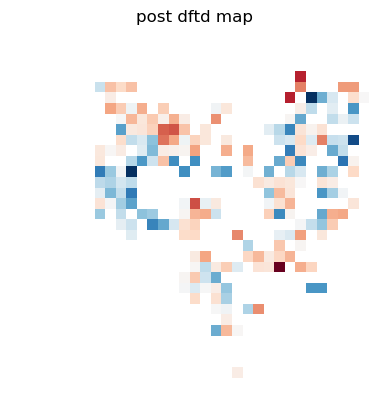

In [64]:
plt.imshow(hs,cmap='RdBu_r',vmin=hs[~np.isnan(hs)].min(),
           vmax=hs[~np.isnan(hs)].max())
plt.title('post dftd map')
plt.axis('off')
plt.show()

In [65]:
#aggregated via median
pre_dftd=correction[correction['dftd']==0]
suitability=pre_dftd[['id','rel_abun','disease length']].groupby('id').median()
suitability.reset_index(inplace=True)

#remove areas outside of grid cell range
for i in range(len(suitability)):
    if int(suitability['id'][i][0])>=gridlen or \
    int(suitability['id'][i][-1])>=gridlen or \
    int(suitability['id'][i][0])<0 or int(suitability['id'][i][-1])<0:
        suitability.drop(i,inplace=True)

#generate raster
hs=np.zeros((gridlen,gridlen))
for i in range(len(suitability)):
    hs[suitability.at[i,'id']]=suitability.at[i,'rel_abun']
hs=np.flip(hs,axis=0)

hs[hs==0]=np.nan

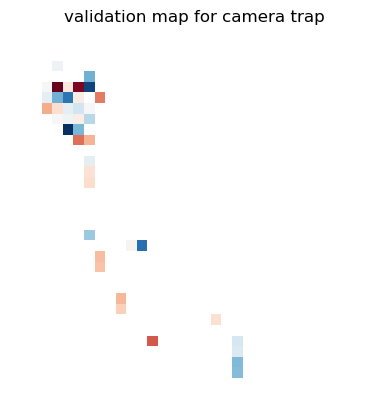

In [66]:
plt.imshow(hs,cmap='RdBu_r',vmin=hs[~np.isnan(hs)].min(),
           vmax=hs[~np.isnan(hs)].max())
plt.title('validation map for camera trap')
plt.axis('off')
plt.show()

In [67]:
#validation target of camera traps
suitability['index']=suitability['id'].apply(lambda x: (gridlen-1-x[0])*gridlen+x[1])
suitability[['index','rel_abun',]].to_csv('C:/Users/tm/Downloads/utas/thesis/chapter1/tasmania/poems/valid_camera.csv',index=False)